In [1]:
import numpy as np
from scipy.stats import norm
S0 =100
K1 = 100
mu =0.1
sigma = 0.2

r = 0.02
T1 = 0.25
#T2 = 0.5 ##gamma use
c1 = 2.5*10**-4  ## transaction cost
#c2 = 10 * 10**-4 ## gamma use

days = 365 ##suppse trading day in one year is 365, we can change it to 252
NoT = int(T1*days) ##number of trade for this option, daily basis
dt = T1/NoT  ## discrete time interval

In [2]:
#%% Greeks using BS closed form
def PutDeltaCal(S, K, sigma, r, t): ## compute Delta of put option
    d1 = (np.log(S/K)+(r + sigma**2/2) * t)/(sigma* np.sqrt(t))
    return norm.cdf(d1)-1

def GammaCal(S, K, sigma, r, t):  ## gamma is the same of put and call
    d1 = (np.log(S/K)+(r + sigma**2/2) * t)/(sigma* np.sqrt(t))
    return norm.pdf(d1)/(S * sigma * np.sqrt(t))

def PutValue(S,K,sigma,r,t):
    d1 = (np.log(S/K)+(r + sigma**2/2) * t)/(sigma* np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return K*np.exp(-r * t)*norm.cdf(-d2) - S*norm.cdf(-d1)

#simulate stock price
def GBM(S0, NoT, T1, mu, sigma, Npaths, rand = 1):
    dt = T1/NoT
    sqrtdt = np.sqrt(dt)
    random = np.random.RandomState(3 * rand)
    dW = sigma * sqrtdt * random.normal(size = [NoT, Npaths])
    X = np.zeros([NoT+1,Npaths])
    X[0,:] =S0
    for i in range(NoT):
        X[i+1,:] = X[i,:] * np.exp((mu-sigma**2/2)*dt +dW[i,:])
    return X

####  timebased rebalance implementation

Adjust the stock position daily to make it Delta neutral

In [3]:
#%%
Npaths = 1000
B = np.zeros([NoT+1,Npaths])  ## bank account
stock_position = np.zeros_like(B)

sigma_real = 0.2
stock_price = GBM(S0, NoT, T1, mu, sigma_real, Npaths)  ## simulat stock price path first
stock_position[0,:] = PutDeltaCal(stock_price[0,:],K1, sigma,r,T1-0*dt) ## initial position 
B[0,:] = PutValue(S0,K1,sigma,r,T1) - stock_position[0,:] * S0 * (1 - c1)##short stock, cost should be subtracted
for i in range(1,NoT):
    stock_position[i,:] = PutDeltaCal(stock_price[i,:],K1, sigma,r,T1-i*dt)
    delta_position = stock_position[i,:] - stock_position[i-1,:] ##delta_position means the change of stock position
    longorshort = np.where(delta_position>=0,1,-1)
    cashflow = - delta_position * stock_price[i,:] * (1 + longorshort*c1) ## money wil be added or subtracted from account
    B[i,:] = B[i-1,:]*np.exp(r*dt) + cashflow

##final account = account_{n-1}*exp(r*dt) + position_{n-1}*Price_{n} - option_payoff
cashflow = stock_position[NoT-1,:] * stock_price[NoT,:] - np.where(K1-stock_price[NoT,:]>=0,K1-stock_price[NoT,:],0)
B[NoT,:] = B[NoT-1,:] * np.exp(r*dt) + cashflow


#### movebased rebalance

Set a bandwidth for the stock position, monitor whether to rebalance or not everu day, only change stock position when the temporary perfect hedged position is far away from the current position.

In [4]:
bandwidth = 0.05
B1 = np.zeros([NoT+1,Npaths])  ## bank account
stock_position1 = np.zeros_like(B1)
upper= np.zeros_like(B1)
lower = np.zeros_like(B1)
trading_times = np.zeros_like(B1)

stock_position1[0,:] = PutDeltaCal(stock_price[0,:],K1, sigma,r,T1-0*dt)
upper[0,:] = stock_position1[0,:] + bandwidth

lower[0,:] = stock_position1[0,:] - bandwidth

B1[0,:] = PutValue(S0,K1,sigma,r,T1) - stock_position1[0,:] * S0 * (1 - c1)##short stock, cost should be minus
for i in range(1,NoT):
    temp_position = PutDeltaCal(stock_price[i,:],K1, sigma,r,T1-i*dt) ## perfect hedged position
    up = temp_position >= upper[i-1,:] ##  break upper bound or not
    low = temp_position <= lower[i-1,:] ##  break lower bound or not
    ##update upper lower and real stock position
    upper[i,:] = np.where(up, temp_position + bandwidth,
         np.where(low , temp_position + bandwidth, upper[i-1,:]))
    lower[i,:] = np.where(up, temp_position - bandwidth,
         np.where(low , temp_position - bandwidth, lower[i-1,:]))
    stock_position1[i,:] = np.where(up, temp_position,
         np.where(low , temp_position, stock_position1[i-1,:]))
    ## update trading times
    trading_times[i,:] = np.where(up | low, trading_times[i-1,:] + 1, trading_times[i-1,:])
    
    delta_position = stock_position1[i,:] - stock_position1[i-1,:]
    longorshort = np.where(delta_position >= 0,1,-1)
    cashflow = - delta_position * stock_price[i,:] * (1 + longorshort*c1)
    B1[i,:] = B1[i-1,:]*np.exp(r*dt) + cashflow

cashflow = stock_position1[NoT-1,:] * stock_price[NoT,:] - np.where(K1-stock_price[NoT,:]>=0,K1-stock_price[NoT,:],0)
B1[NoT,:] = B1[NoT-1,:] * np.exp(r*dt) + cashflow
trading_times[NoT,:] = np.where(stock_position1[i-1,:]!=0, trading_times[NoT-1,:]+1,trading_times[NoT-1,:])


Text(-1.79962,70.0952,'Diff Stdev = 0.2316')

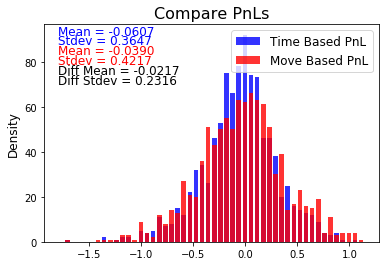

In [6]:
#%% pnl histgram
import matplotlib.pyplot as plt
qt12 = np.percentile(B1[NoT,:],99.9)
qt11 = np.percentile(B[NoT,:],0.05)
bins1 = np.arange(qt11,qt12,(qt12-qt11)/51)
def stats(x):
    mean = np.mean(x)
    std = np.std(x,ddof=1)
    return [('%.4f' %mean), ('%.4f' %std)]

a = plt.hist(B[NoT,:],bins1, histtype = 'bar',label = 'Time Based PnL',color='b',rwidth=0.75,alpha=0.8)
plt.hist(B1[NoT,:],bins1,histtype = 'bar',label = 'Move Based PnL',color='r',rwidth=0.75,alpha=0.8)
plt.ylabel('Density',fontsize=12)
plt.title('Compare PnLs',fontsize =16)
plt.legend(loc = 1,fontsize = 'large')
height = max(a[0]) ; perheight = height/21
xmin = min(a[1]); xmax = max(a[1])
perlength = (xmax - xmin)/6
plt.text(xmin, height,'Mean = '+stats(B[NoT,:])[0],color ='b',fontsize = 12)
plt.text(xmin,height- perheight, 'Stdev = '+stats(B[NoT,:])[1],color ='b',fontsize = 12)
plt.text(xmin, height- 2* perheight,'Mean = '+stats(B1[NoT,:])[0],color ='r',fontsize = 12)
plt.text(xmin,height- 3*perheight, 'Stdev = '+stats(B1[NoT,:])[1],color ='r',fontsize = 12)
plt.text(xmin, height -4*perheight, 'Diff Mean = '+stats(B[NoT,:]-B1[NoT,:])[0],color ='k',fontsize = 12)
plt.text(xmin, height -5*perheight, 'Diff Stdev = '+stats(B[NoT,:]-B1[NoT,:])[1],color ='k',fontsize = 12)

Text(0,0.5,'Delta')

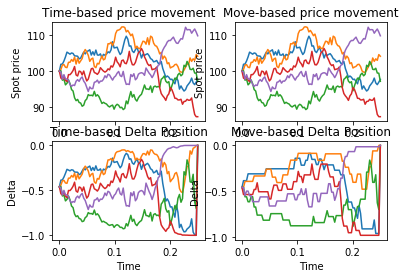

In [7]:
#%% historical stock position for the first 5 path
plt.subplot(2,2,1)
plt.plot(np.arange(0,NoT+1)/(NoT/T1),stock_price[:,:5])
plt.title('Time-based price movement')
plt.xlabel('Time')
plt.ylabel('Spot price')
plt.subplot(2,2,2)
plt.plot(np.arange(0,NoT+1)/(NoT/T1), stock_price[:,:5])
plt.title('Move-based price movement')
plt.xlabel('Time')
plt.ylabel('Spot price')
plt.subplot(2,2,3)
plt.plot(np.arange(0,NoT+1)/(NoT/T1),stock_position[:,:5])
plt.title('Time-based Delta Position')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.subplot(2,2,4)
plt.plot(np.arange(0,NoT+1)/(NoT/T1),stock_position1[:,:5])
plt.title('Move-based Delta Position')
plt.xlabel('Time')
plt.ylabel('Delta')